<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/7_multi_model_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check for causality

😈 **Task 3:** Run a Granger test between `temp` and `o3`. Is there any directional causality?

😈 **Question 3:** Why is Granger causality not the same as actual causality?


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
for col in ["no2", "temp", "no", "press"]:
    print(f"\nTesting if {col} Granger-causes o3:")
    grangercausalitytests(dataframe[['o3', col]], maxlag=4)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

def multi_model_plotting(X_test_full, y_test_full, station_code, paths_to_forecasts, model_names, variable_column, variable_idx, scaler_stats):
    plt.figure(figsize=(12, 10))

    context_window = X_test_full.shape[1]  # Number of time steps in the context
    prediction_horizon = y_test_full.shape[1]  # Number of time steps in the prediction

    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == station_code)[0]
    X_test_sample=X_test_full[X_first_idx, :, variable_idx+1] # First column is station code hence adding 1#

    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == station_code)[0]
    y_test_sample=y_test_full[y_first_idx, :, variable_idx+1] # First column is station code hence adding 1

    # initialize plot
    plt.subplot(1, 1, variable_idx + 1)

    # Define a color map for different models
    colors = plt.cm.get_cmap('tab10', len(paths_to_forecasts))
    predicted_timepoints_ind = np.zeros((context_window + prediction_horizon,))
    for i, (path, model_name) in enumerate(zip(paths_to_forecasts, model_names)):
        # load predictions
        forecasts = pd.read_csv(path)
        predicted_future = forecasts['forecast'].to_list()
        predicted_timepoints = forecasts['timepoints'].to_list()

        # keep track of which timepoints were predicted
        predicted_timepoints_ind[predicted_timepoints] = 1

        # plot predictions with color
        plt.plot(predicted_timepoints, predicted_future, label=f"{model_name} Prediction", linestyle="--", color=colors(i))
    
    # Inverse scale
    context = X_test_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']
    actual_future = y_test_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']

    # plot context and actual future based on which timepoints were predicted
    # since we do not want to assume which timepoints were used as context and as ground truth, we plot based on indices of predicted timepoints
    
    all_values = np.concatenate([context, actual_future]) # concatenate to distinguish later
    all_timepoints = np.arange(context_window + prediction_horizon)

    # plot context
    context_values = all_values[predicted_timepoints_ind == 0]
    context_timepoints = all_timepoints[predicted_timepoints_ind == 0]
    plt.plot(context_timepoints, context_values, label="Context", color="blue", linestyle="-")

    # plot ground truth
    ground_truth_values = all_values[predicted_timepoints_ind == 1]
    ground_truth_timepoints = all_timepoints[predicted_timepoints_ind == 1]
    plt.plot(ground_truth_timepoints, ground_truth_values, label="Ground Truth", color="lightblue", linestyle="-")


    plt.title(f"MLP Forecast for {variable_column[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(variable_column[variable_idx])
    plt.legend()

    plt.tight_layout()
    plt.show()


In [2]:
import gdown

gdown.download(id="1XsCWRTpSZOBhZuL-a7OQ31PXa6ENvr1Q", output="X_test.pkl", quiet=True)
gdown.download(id="1gs6gpCGocrob3il3gZgnKXFLm95r4Tyi", output="y_test.pkl", quiet=True)

'y_test.pkl'

In [22]:
import pickle
import pandas as pd


with open("X_test.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test_full = pickle.load(f)

variable_column = ["temp"]

url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
dataframe = pd.read_csv(url, parse_dates=["datetime"])
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}
station_code = "DENW094"
variable_idx = 0

C:\Users\ameri\AppData\Local\Temp\ipykernel_4372\1226383454.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(paths_to_forecasts))


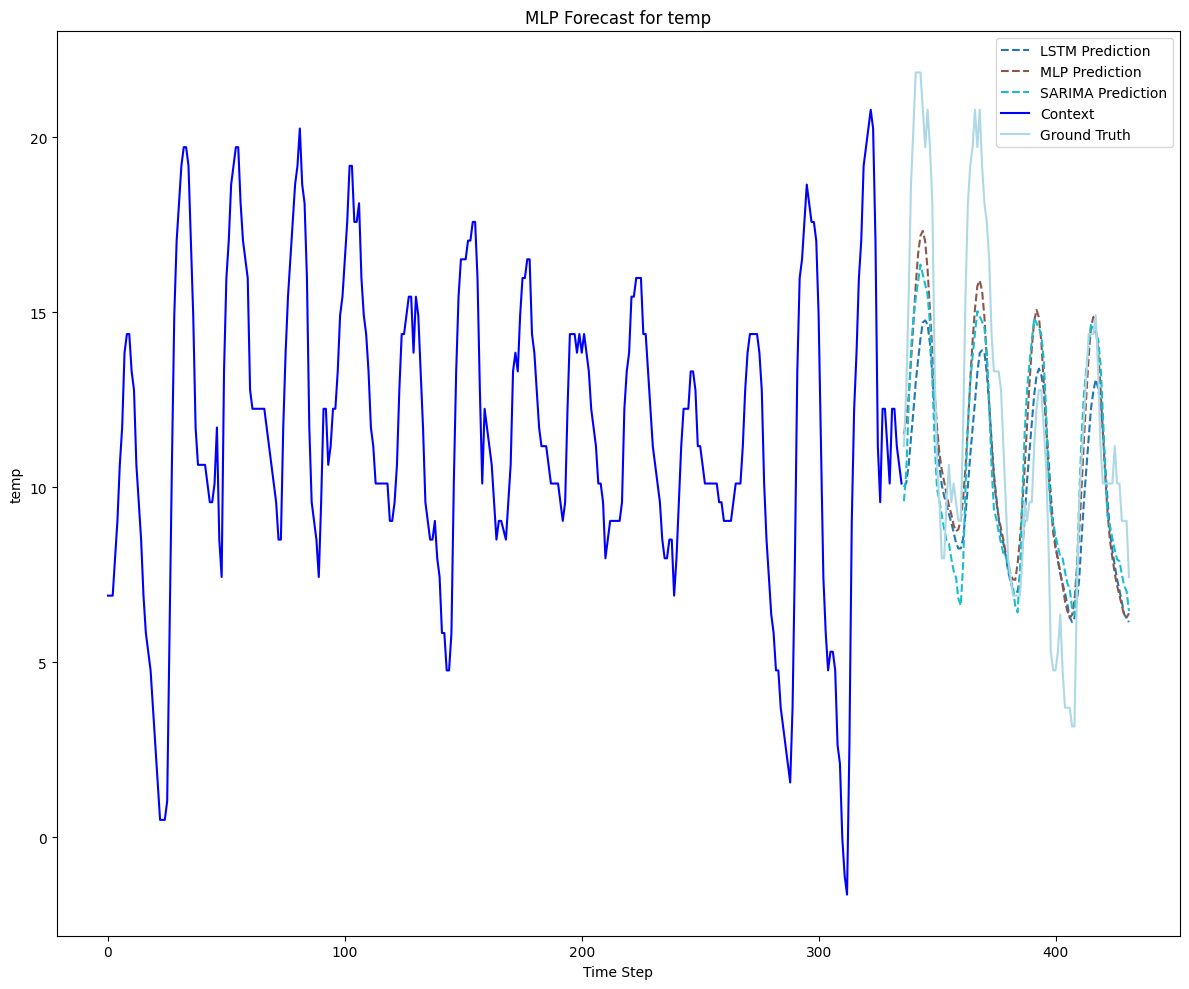

In [33]:
predicted_paths = [
    "model_results/LSTM_forecast.csv",
    "model_results/MLP_forecast.csv",
    "model_results/sarima_forecast.csv",
]

model_names = ["LSTM", "MLP", "SARIMA"]
multi_model_plotting(X_test_full, y_test_full, station_code, predicted_paths, model_names, variable_column, variable_idx, scaler_stats)